In [ ]:
from data import *
import matplotlib.pyplot as plt

In [ ]:
train_df = get_mnist_df()
valid_df = get_mnist_df(train=False)
train_df.shape, valid_df.shape

((60000, 2), (10000, 2))

In [ ]:
train_df.head(2)

,path,label
0,data/mnist_png/training/9/6813.png,9
1,data/mnist_png/training/9/6838.png,9


In [ ]:
img = get_img(train_df.path.iloc[0])
img

In [ ]:
train_dl, valid_dl = get_dls(train_df, valid_df, bs=64)
batch = next(iter(train_dl))
batch[0].shape

torch.Size([64, 1, 28, 28])

## Some plotting functionality to help with showing our original vs generated images

In [ ]:
b1 = batch[0][:8]
b2 = batch[0][8:16]
b1.shape, b2.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

In [ ]:
def get_subplot(img, row=1, cols=2, item=1):
    ax = plt.subplot(row, cols, item)
    ax.imshow(np.array(img.squeeze()))
    ax.axis('off')
    return ax

def plt_subs(og_imgs, gen_imgs, size=3):
    rows = int(len(og_imgs) / 2)
    cols = 4
    fig = plt.figure(figsize=(size*2, size*rows))

    for idx, imgs in enumerate(zip(og_imgs, gen_imgs)):
        ax1 = get_subplot(imgs[0], row=rows, cols=cols, item=2*idx+1)
        ax2 = get_subplot(imgs[1], row=rows, cols=cols, item=2*idx+2)
        if idx == 0 or idx == 1:
            ax1.set_title("Original Images", fontdict={'fontsize':7})
            ax2.set_title("Generated Images", fontdict={'fontsize':7})
    plt.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.subplots_adjust(top=0.5)

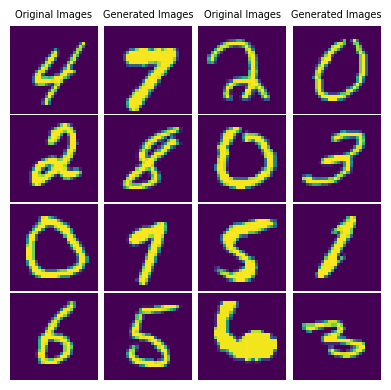

In [ ]:
plt_subs(b1, b2, size=2)

#### We now have plotting functionality to allow us to compare original images to their generated counterparts

In [ ]:
def get_encoder():
    return torch.nn.Sequential(torch.nn.Conv2d(1, 28, 3, 2, 1),
                              torch.nn.ReLU(),
                              torch.nn.Conv2d(28, 64, 3, 2, 1),
                              torch.nn.ReLU(),
                              torch.nn.Conv2d(64, 128, 3, 2, 1),
                              torch.nn.ReLU(),
                              torch.nn.Flatten(),
                              torch.nn.Linear(2048, 2)
                             )

In [ ]:
def get_decoder():
    return torch.nn.Sequential(torch.nn.Linear(2, 2048),
                                torch.nn.ReLU(),

                                # Unflatten
                                torch.nn.Unflatten(1, (128, 4, 4)),

                                # Upsample
                                torch.nn.ConvTranspose2d(128, 64, 3, 2, 1,),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(64, 28, 4, 2, 1,),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(28, 1, 4, 2, 1,)  # Use a kernel size of 4 here
                            )

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = get_encoder()
        self.decoder = get_decoder()
    
    def forward(self, x):
#        pdb.set_trace()
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x

In [ ]:
dls = DataLoaders(train_dl, valid_dl)
dls = dls.to('cuda')

In [ ]:
learner = Learner(dls, Autoencoder(), loss_func=MSELossFlat(), ).to_fp16()
learner.fine_tune(2, 3e-2)

epoch,train_loss,valid_loss,time
0,3414.484375,3243.834717,00:08


epoch,train_loss,valid_loss,time
0,3024.529541,3018.455322,00:08
1,2827.781982,2817.714111,00:08


In [ ]:
def get_valid_results(model, dl, num_samples=4):
    batch = next(iter(dl))
    output = model(batch[0].cuda()).detach().cpu()
    return batch[0][:num_samples].cpu(), output[:num_samples]

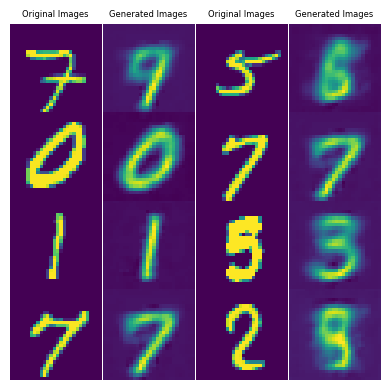

In [ ]:
og_imgs, gen_imgs = get_valid_results(learner.model, dls.train, num_samples=8)
plt_subs(og_imgs, gen_imgs, size=2)

In [ ]:
def get_embed_plot(model):
    test_ds = LabeledDataset(valid_df)
    test_dl = DataLoader(test_ds, batch_size=512, shuffle=False)
    model.to('cpu');
    test_embeds = [model.encode(batch[0]) for batch in test_dl]
    embeds = torch.vstack(test_embeds[:-1]).detach().numpy()
    lbls = [batch[1] for batch in test_dl]
    lbls = np.hstack([np.array(x).astype('int') for x in lbls[:-1]])
    plt.scatter(embeds[:, 0], embeds[:, 1], c=lbls, s=3, cmap='rainbow')
    plt.plot(2,20, 'ro')
    plt.colorbar()
    plt.show()

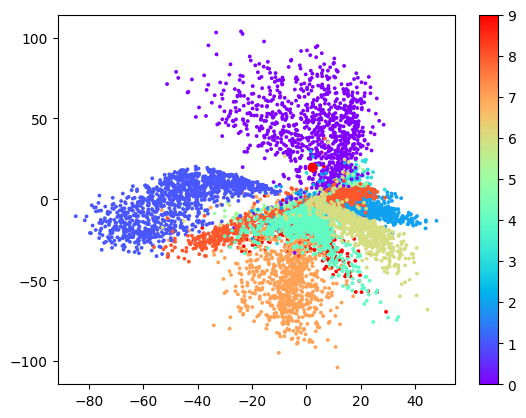

In [ ]:
get_embed_plot(learner.model)

In [ ]:
def plot_regen(model, x=2, y=20):
    regen = model.decode(torch.tensor([x,y]).float().unsqueeze(0))
    plt.imshow(regen.squeeze().detach().numpy())

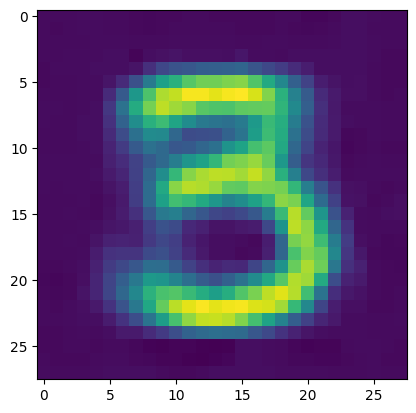

In [ ]:
plot_regen(learner.model, x=20, y=10)

In [ ]:
learner = Learner(dls, Autoencoder(), loss_func=MSELossFlat(), ).to_fp16()
learner.fine_tune(10, 3e-1)

epoch,train_loss,valid_loss,time
0,4457.381348,4462.031250,00:09


epoch,train_loss,valid_loss,time
0,4380.881348,4396.578613,00:09
1,4369.358887,4403.636230,00:09
2,4422.305176,4447.104980,00:09
3,4402.302734,4405.910645,00:09
4,4360.163574,4420.194336,00:09
5,4391.961914,4395.602051,00:08
6,4396.675781,4394.964355,00:09
7,4373.316895,4391.890137,00:09
8,4367.094727,4388.964844,00:09
9,4346.027832,4389.003418,00:09


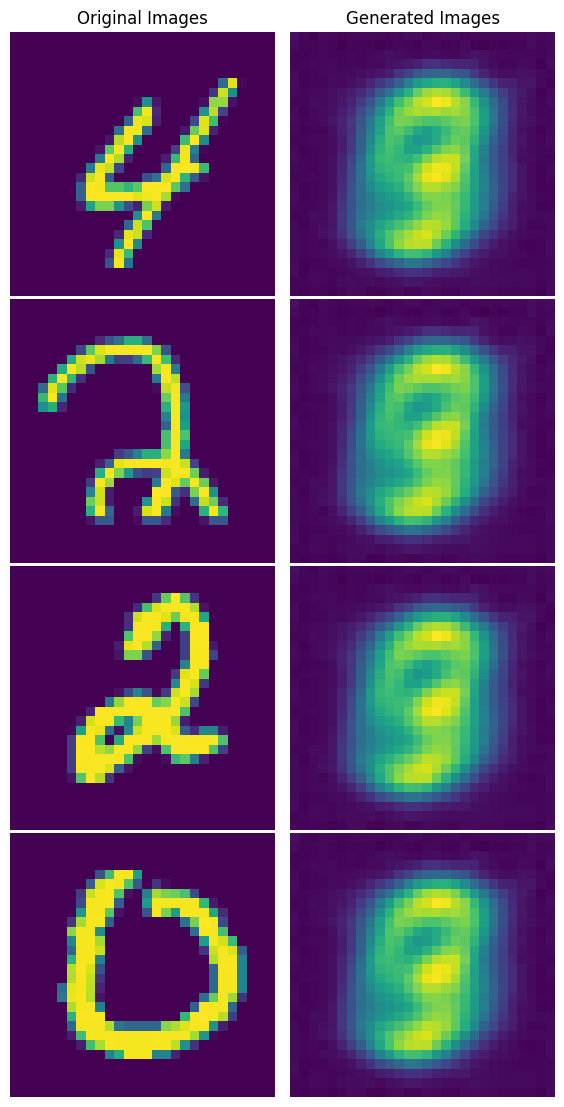

In [ ]:
output = learner.model(batch[0].cuda()).detach().cpu()
plt_subs(batch[0][:4].cpu(), output[:4])

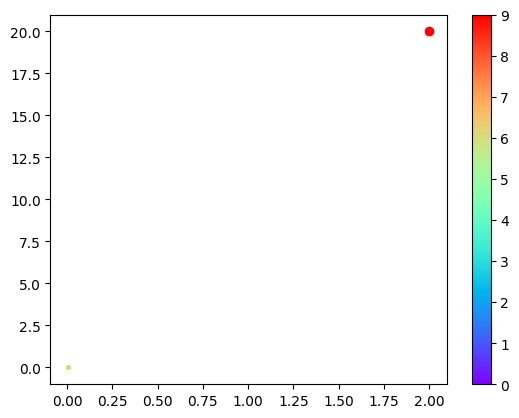

In [ ]:
get_embed_plot(learner.model)

In [ ]:
get_valid_resultsr = Learner(dls, Autoencoder(), loss_func=MSELossFlat(), ).to_fp16()
learner.fine_tune(20, 3e-3)

epoch,train_loss,valid_loss,time
0,3263.639893,3181.919922,00:08


epoch,train_loss,valid_loss,time
0,3007.714844,2993.816406,00:08
1,2960.449951,2933.150879,00:09
2,2932.466553,2917.204346,00:09
3,2872.346680,2869.713623,00:09
4,2886.185303,2903.034912,00:09
5,2845.536621,2840.021973,00:09
6,2816.304199,2816.199707,00:09
7,2750.739990,2751.230225,00:08
8,2734.307373,2715.794678,00:08
9,2691.731689,2704.523438,00:09


KeyboardInterrupt: 

In [ ]:
output = learner.model(batch[0].cuda()).detach().cpu()
plt_subs(batch[0][:4].cpu(), output[:4])

In [ ]:
get_embed_plot(learner.model)

So we have dataloaders that can give us our images.

We now need an abstraction model class for both encoder and decoder and lets create our first AutoEncoder!

In [ ]:
embeds.mean(axis=0)

In [ ]:
learner.model.decode